#### Učitavanje potrebnih biblioteka

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from skimage import io, color, morphology, filters
import os

In [35]:
%matplotlib inline

# Zadatak 1
U timu predmeta na MSTeams platformi dostupna je baza slikanih šaka koje pokazuju „papir“, „kamen“ i „makaze“. 
Projektovati inovativni sistem za prepoznavanje pokazanih znakova zasnovan na testiranju hipoteza. 

a) Detaljno opisati algoritam za obradu slike i odabir obeležja koji prethodi samoj klasifikaciji. Algoritam treba da bude 
što robusniji (na različite osvetljaje, položaje šaka, načine pokazivanja znakova itd). 

b) Izvršiti podelu na trening i test skup. Rezultate klasifikacije test skupa prikazati u obliku matrice konfuzije. 

c) Odabrati dva znaka i dva obeležja takva da su odabrani znakovi što separabilniji u tom prostoru. Prikazati histogram 
obeležja za oba slova i prokomentarisati njihov oblik. 

d) Za slova i obeležja pod c) projektovati parametarski klasifikator po izboru i iscrtati klasifikacionu liniju. 

### Funkcija za preprocesiranje slike

Na slikama se nalaze različiti znakovi rukom (papir, kamen ili makaze) na zelenoj pozadini. Ideja je da od originalne RGB slike dobijemo binarnu sliku, gde će belom bojom biti predstavljena ruka, dok će pozadina biti crna.

Funkcija process_image dobija kao ulaz putanju do slike, a vraća obrađenu sliku.
Nakon što se slika učita, ona se iz RGB formata prebacuje u HSV(hue, saturation, value) format radi lakše segmentacije - u ovom formatu imamo jednostavnije definisanje opsega za određene boje, nezavisno od osvetljenja i senki. Nakon toga se definiše opseg za zelenu boju - što će predstavljati našu pozadinu.

Pomoću ovako definisanih granica, binarizujemo originalnu sliku - tako da je pozadina bele boje, a ruka crne, a potom tu binarizovanu sliku invertujemo kako bismo dobili željenu binarnu sliku, gde je ruka bela, a pozadina crna. Nakon toga vršimo inicijalno uklanjanje ivica (po 10 piksela sa svake strane) kako bi se odstranili potencijalno loše segmentisani delovi slike po ivicama.

Nad ovako dobijenom slikom vrši se zatvaranje slike kako bi se popunile sve potencijalne praznine nastale usled pogreški pri segmentaciji. Zatvaranje slike se vrši tako što se najpre primeni diletacija, a potom i erozija. Diletacija će popuniti potencijalne praznine, dok će erozija bolje oblikovati konturu nakon procesa diletacije. Za oba procesa su korišćeni su strukturni elementi dobijeni morphology.disk(2) jer obezbeđuju ivice koje su glađe u odnosu na one koje se dobijaju korišćenjem kvadratnog strukturnog elementa.

Izgled morphology.disk(2): $$
\begin{bmatrix}
0 & 1 & 1 & 1 & 0 \\
1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 \\
0 & 1 & 1 & 1 & 0 \\
\end{bmatrix}
$$


Nakon zatvaranja slike se vrši filtriranje slike median filtrom sa maskom $7\times 7$ kako bi se otklonio "salt & pepper" šum ukoliko ga ima.

Poslednji korak u obradi slike jeste kropovanje slike, tako da se granice slike pomere ka unutra, tako da obuhvataju samo šaku. Leva granica će se pomerati ulevo sve dok ne naiđe na kolonu koja sadrži bar jedan beli piksel, analogno za ostale granice.

In [2]:
def process_image(image_path):
    image = io.imread(image_path)
    image_hsv = color.rgb2hsv(image)

    lower_green = np.array([0.25, 0.2, 0.2])  
    upper_green = np.array([0.45, 1.0, 1.0])

    image_binary = ((image_hsv[..., 0] >= lower_green[0]) & (image_hsv[..., 0] <= upper_green[0]) &
                   (image_hsv[..., 1] >= lower_green[1]) & (image_hsv[..., 1] <= upper_green[1]) &
                   (image_hsv[..., 2] >= lower_green[2]) & (image_hsv[..., 2] <= upper_green[2]))

    image_binary = ~image_binary
    image_binary = image_binary[10:image_binary.shape[0]-10, 10:]
    
    dilated = morphology.dilation(image_binary, morphology.disk(2))
    eroded = morphology.erosion(dilated, morphology.disk(2))

    closed_image = eroded.astype(np.uint8) * 255
    
    filtered_image = filters.median(closed_image, np.ones((7, 7), dtype=bool))
    
    M,N = np.shape(filtered_image)

    left = 0
    while(left < N-1 and np.sum(filtered_image[:, left] == 255) == 0):
        left += 1
    
    right = N-1
    while(right > 0 and np.sum(filtered_image[:, right] == 255) == 0):
        right -= 1
    
    up = 0
    while(up < M-1 and np.sum(filtered_image[up, :] == 255) == 0):
        up += 1
    
    down = M-1
    while(down > 0 and np.sum(filtered_image[down, :] == 255) == 0):
        down -= 1

    cropped_image = filtered_image[up:down, left:right]

    return cropped_image


## Odabir atributa

Jedan atribut će nam biti procenat belih piksela u delu slike. Deo slike u kome posmatramo jeste deo od kolone $\lfloor \frac{width}{7.5} \rfloor$ do kolone $\lfloor \frac{width}{2.5} \rfloor$, gde width predstavlja širinu slike.

Drugi argument će biti odnos visine i širine slike : $\frac{height}{width} \cdot 100 \text{%} $

Motiv za odabir prvog atribut : Kod makaza očekujemo da se u tom delu slike javlja praznina zbog razmaka između kažiprsta i srednjeg prsta prilikom prikazivanja ovog znaka, dok kod kamena bi taj deo trebalo da bude ispunjen belim pikselima jer je tada stisnuta pesnica.

Motiv za odabir drugog atribut : Pošto kod makaza imamo ispružene prste, očekujemo da kropovana slika bude nešto šira nego kod znaka kamen, gde su svi prsti skupljeni. Gledamo odnos širine i visine kako bismo imali neki vid normalizacije.

In [3]:
def calculate_white_percentage(image):
    width = image.shape[1]
    
    start = int(np.floor(width / 7.5))
    stop = int(np.floor(width / 2.5))
    
    left_part = image[:, start:stop]
    
    white_pixels = np.sum(left_part == 255)
    total_pixels = left_part.size
    
    percentage = (white_pixels / total_pixels)
    
    return percentage

In [14]:
from scipy import ndimage

def distance_transform_and_centroid(img):
    binary = (img > 0).astype(np.uint8)

    dist = ndimage.distance_transform_edt(binary)

    coords = np.column_stack(np.nonzero(binary)) 

    y_mean = coords[:, 0].mean()
    x_mean = coords[:, 1].mean()
    centroid = (x_mean, y_mean)

    return centroid

In [15]:
def find_features(images):
    features = np.zeros((2, len(images)))
    
    for i, image in enumerate(images):
        features[0, i] = calculate_white_percentage(image)
        centroid = distance_transform_and_centroid(image)
        features[1, i] = centroid[0]/centroid[1]
    
    return features

## Preprocesiranje slika
U promenljivu path je potrebno uneti putanju do foldera ROCKPAPERSCISSORS. Zatim se kreira putanja do svakog od foldera paper, rock scissors, prolazi se kroz slike koje se nalaze u folderima i procesirane slike se stavljaju u listu koja odgovara folderu iz kog dolaze.

In [6]:
rock_processed = [] 
scissors_processed = []
paper_processed = []

path = r'D:\ETF\semestar7\PO\Projekat'
folder_path = os.path.join(path, 'ROCKPAPERSCISSORS')
folder_paper = os.path.join(folder_path,'paper')
folder_rock = os.path.join(folder_path,'rock')
folder_scissors = os.path.join(folder_path,'scissors')

for filename in os.listdir(folder_scissors):
    image_path = os.path.join(folder_scissors, filename)
    scissors_processed.append(process_image(image_path))

for filename in os.listdir(folder_rock):
    image_path = os.path.join(folder_rock, filename)
    rock_processed.append(process_image(image_path))
    
for filename in os.listdir(folder_paper):
    image_path = os.path.join(folder_paper, filename)
    paper_processed.append(process_image(image_path))

### Primer obradjenih slika

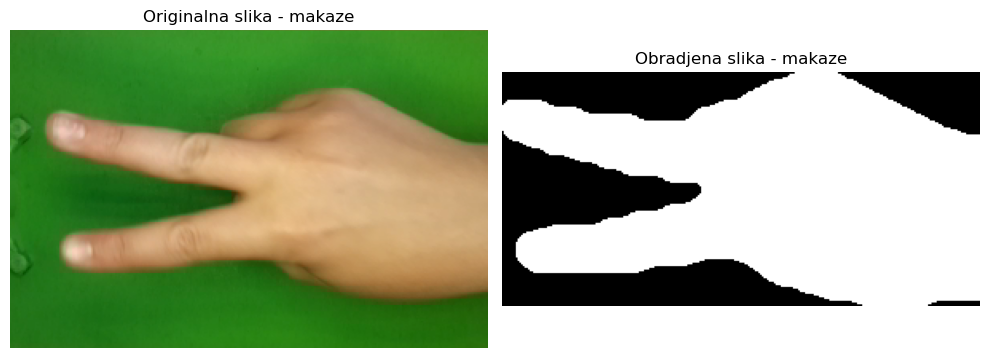

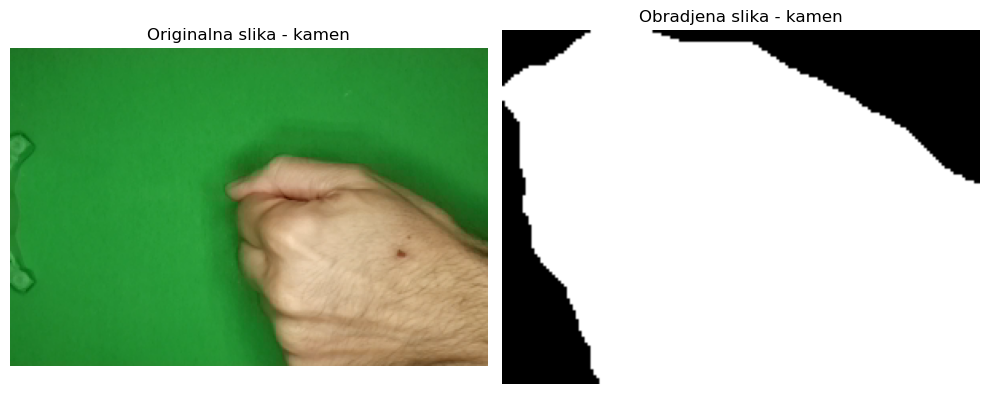

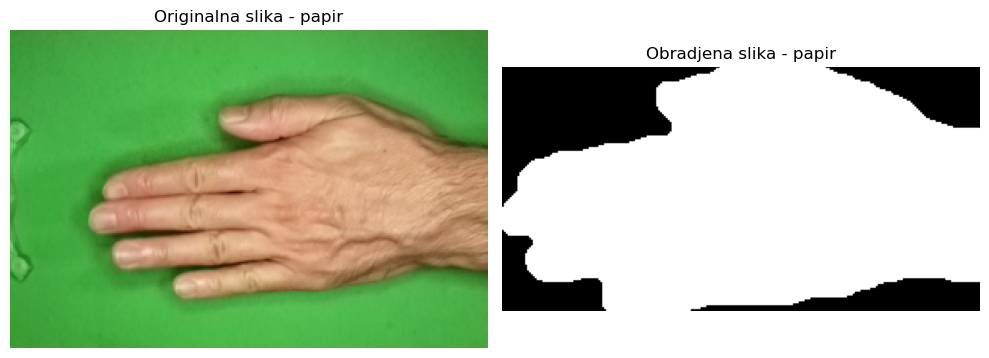

In [7]:
image_path = os.path.join(folder_scissors, os.listdir(folder_scissors)[2])
image = process_image(image_path)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(io.imread(image_path))
ax[0].set_title("Originalna slika - makaze")
ax[0].axis("off")

ax[1].imshow(image, cmap='gray')
ax[1].set_title("Obradjena slika - makaze")
ax[1].axis("off")

plt.tight_layout()
plt.show()


image_path = os.path.join(folder_rock, os.listdir(folder_rock)[2])
image = process_image(image_path)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(io.imread(image_path))
ax[0].set_title("Originalna slika - kamen")
ax[0].axis("off")

ax[1].imshow(image, cmap='gray')
ax[1].set_title("Obradjena slika - kamen")
ax[1].axis("off")

plt.tight_layout()
plt.show()


image_path = os.path.join(folder_paper, os.listdir(folder_paper)[0])
image = process_image(image_path)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(io.imread(image_path))
ax[0].set_title("Originalna slika - papir")
ax[0].axis("off")

ax[1].imshow(image, cmap='gray')
ax[1].set_title("Obradjena slika - papir")
ax[1].axis("off")

plt.tight_layout()
plt.show()

## Klasifikacija sva tri znaka

In [65]:
def gaussian_pdf(X, M, S):
    detS = np.linalg.det(S)
    invS = np.linalg.inv(S)
    n = S.shape[1]
    f = 1/(((2*np.pi)**(n/2)) * (detS**0.5)) * np.exp(-0.5 * (X-M).T @ invS @ (X-M))
    return f[0,0]


def plot_cm(Y, Y_pred):
    cm = confusion_matrix(Y, Y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    
def predict(X, M_list, S_list, P_list):
    Y_pred = np.zeros(X.shape[1], dtype=int)
    for i in range(X.shape[1]):
        odb = X[:, i].reshape(-1, 1)
        qs = []
        for M, S, P in zip(M_list, S_list, P_list):
            qs.append(P * gaussian_pdf(odb, M, S))
        Y_pred[i] = np.argmax(qs) + 1
    return Y_pred

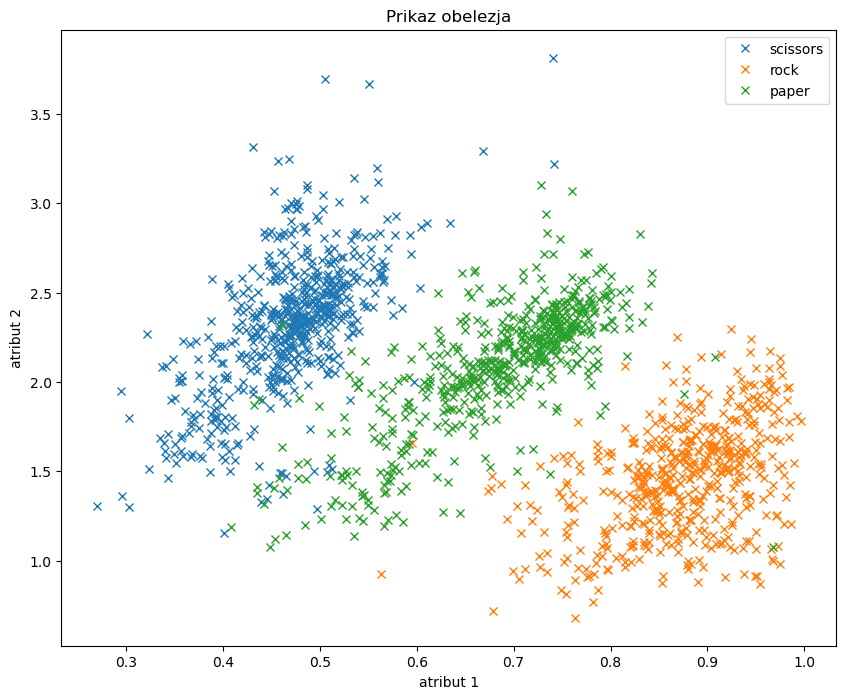

In [68]:
features_paper = find_features(paper_processed)
features_rock = find_features(rock_processed)
features_scissors = find_features(scissors_processed)

X = np.concatenate((features_scissors, features_rock, features_paper), axis=1)
Y = np.ones((X.shape[1]))
s_dim = features_scissors.shape[1]
r_dim = features_rock.shape[1]
p_dim = features_paper.shape[1]

Y[s_dim:s_dim+r_dim] = 2
Y[s_dim+r_dim:] = 3

X_train, X_test, Y_train, Y_test = train_test_split(X.T, Y, test_size=0.2, stratify=Y, random_state=42)
X_train = X_train.T
X_test = X_test.T
X1 = X_train[:,Y_train==1]
X2 = X_train[:,Y_train==2]
X3 = X_train[:,Y_train==3]

plt.figure(figsize=(10,8))
plt.plot(X1[0,:], X1[1,:], 'x')
plt.plot(X2[0,:], X2[1,:], 'x')
plt.plot(X3[0,:], X3[1,:], 'x')
plt.legend(['scissors', 'rock', 'paper'])
plt.title('Prikaz obelezja')
plt.xlabel('atribut 1')
plt.ylabel('atribut 2')
plt.show()

M1 = np.mean(X1, axis=1, keepdims=True)
M2 = np.mean(X2, axis=1, keepdims=True)
M3 = np.mean(X3, axis=1, keepdims=True)
S1 = np.cov(X1)
S2 = np.cov(X2)
S3 = np.cov(X3)
P1 = X1.shape[1]/X_train.shape[1]
P2 = X2.shape[1]/X_train.shape[1]
P3 = 1 - P1 - P2

### Trening set

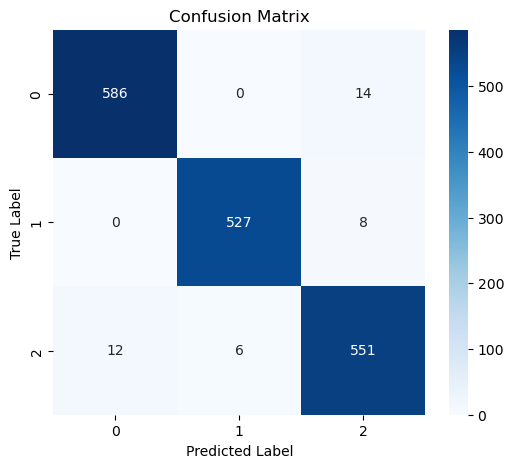

In [69]:
Y_train_pred = predict(X_train, [M1, M2, M3], [S1, S2, S3], [P1, P2, P3])
plot_cm(Y_train, Y_train_pred)

In [71]:
print(f'Preciznost na trening skupu je {np.sum(Y_train==Y_train_pred)/len(Y_train)*100:.2f} %')

Preciznost na trening skupu je 97.65 %


### Test set

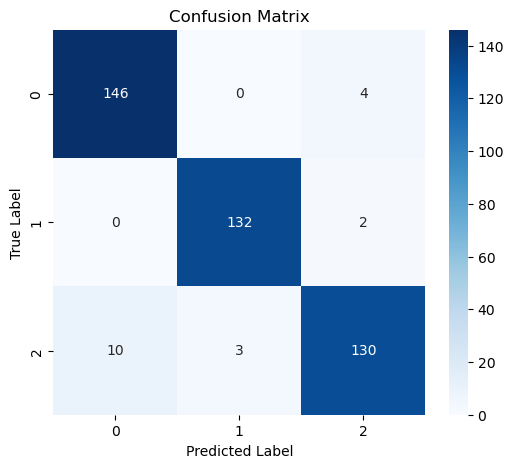

In [73]:
Y_test_pred = predict(X_test, [M1, M2, M3], [S1, S2, S3], [P1, P2, P3])
plot_cm(Y_test, Y_test_pred)

In [76]:
print(f'Preciznost na trening skupu je {np.sum(Y_test==Y_test_pred)/len(Y_test)*100:.2f} %')

Preciznost na trening skupu je 95.55 %


## Klasifikacija dva znaka


Znakovi koji će biti klasifikovani su scissors i rock kojima će redom biti dodeljene labele 1 i 2.

### Izdvajanje obeležja

In [22]:
features_s = find_features(scissors_processed)
features_r = find_features(rock_processed)

### Analiza balansiranosti

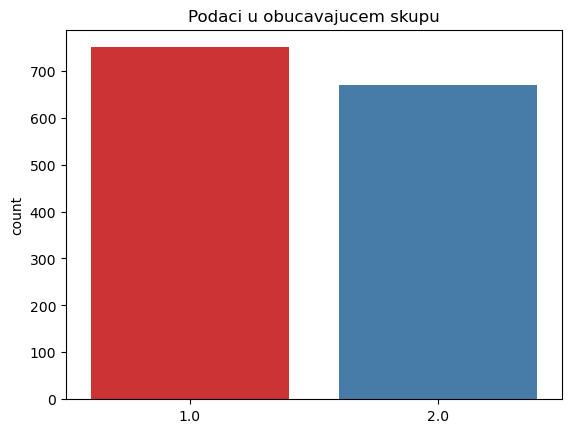

In [23]:
X = np.concatenate((features_s, features_r), axis=1)
Y = np.ones((X.shape[1]))
Y[features_s.shape[1]:] = 2

plt.figure()
sns.countplot(x=Y, palette='Set1', hue=Y, legend=False)
plt.title('Podaci u obucavajucem skupu')
plt.show()

Vidimo da je skup balansiran, međutim svakako možemo pri poredli na test i trening skup vršiti stratifikaciju.

### Podela na trening i test skup

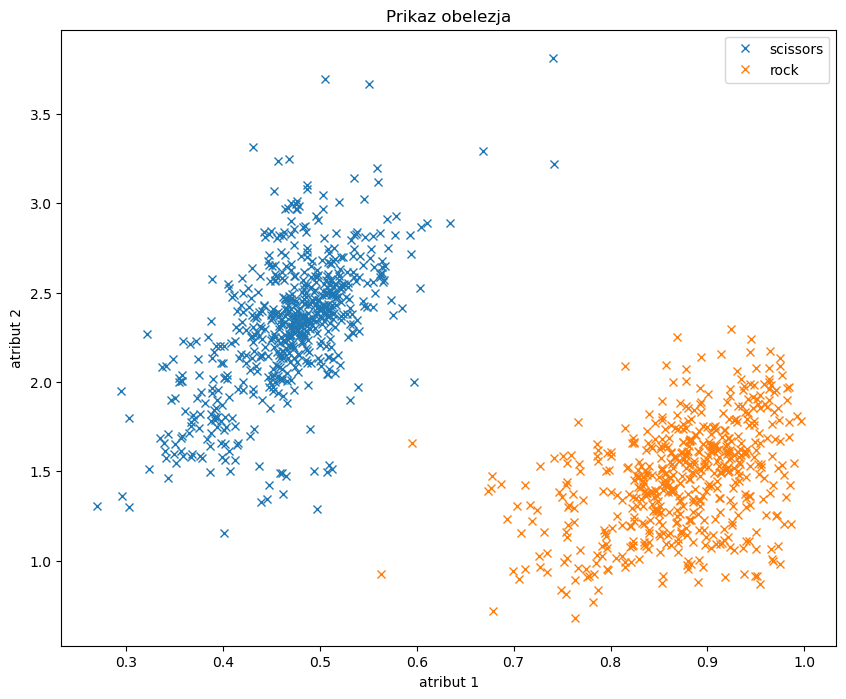

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X.T, Y, test_size=0.2, stratify=Y, random_state=42)
X_train = X_train.T
X_test = X_test.T
X1 = X_train[:,Y_train==1]
X2 = X_train[:,Y_train==2]

plt.figure(figsize=(10,8))
plt.plot(X1[0,:], X1[1,:], 'x')
plt.plot(X2[0,:], X2[1,:], 'x')
plt.legend(['scissors', 'rock'])
plt.title('Prikaz obelezja')
plt.xlabel('atribut 1')
plt.ylabel('atribut 2')
plt.show()

### Histogrami

Biće prikazani 2d histogrami za svaku klasu, kao i histogrami za svako obeležje zasebno

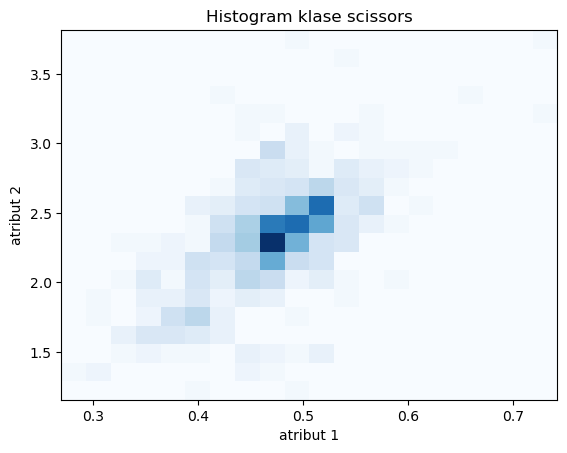

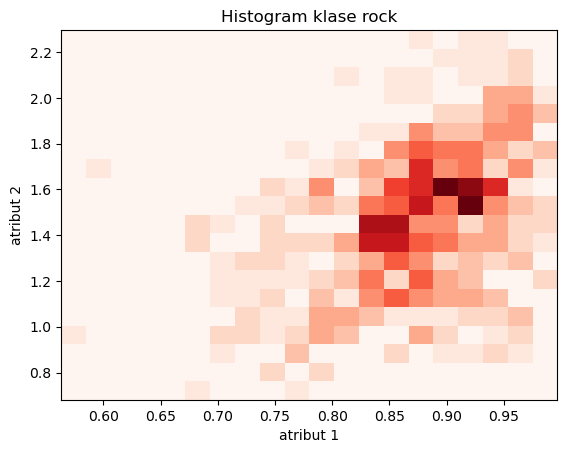

In [25]:
plt.figure()
plt.hist2d(X1[0,:], X1[1,:], bins=20, alpha=1, cmap='Blues')
plt.title('Histogram klase scissors')
plt.xlabel('atribut 1')
plt.ylabel('atribut 2')
plt.show()

plt.figure()
plt.hist2d(X2[0,:], X2[1,:], bins=20, alpha=1, cmap='Reds')
plt.title('Histogram klase rock')
plt.xlabel('atribut 1')
plt.ylabel('atribut 2')
plt.show()

Histogram klase scissors: Klasa je koncentrisana u užem opsegu vrednosti oba obeležja, uočavamo grupisanost oko centra i izražen peak. Ovo sugeriše da klasa ima relativno malu varijansu.

Histogram klase rock : Takođe se vidi centralna tendencija, međutim rasejanje ove klase je dosta veće.

Povoljna stvar za klasifikaciju jeste to što su centri dosta udaljeni jedni od drugih.

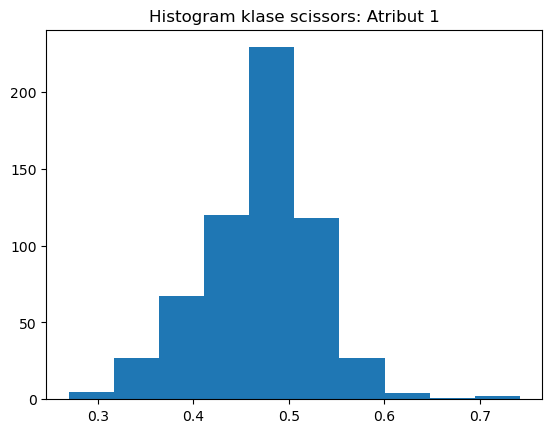

In [26]:
plt.hist(X1[0,:])
plt.title('Histogram klase scissors: Atribut 1')
plt.show()

Raspodela je relativno simetrična i liči na Normalnu raspodelu. Većina odbiraka se nalazi u opsegu vrednosti od 40 do 60.

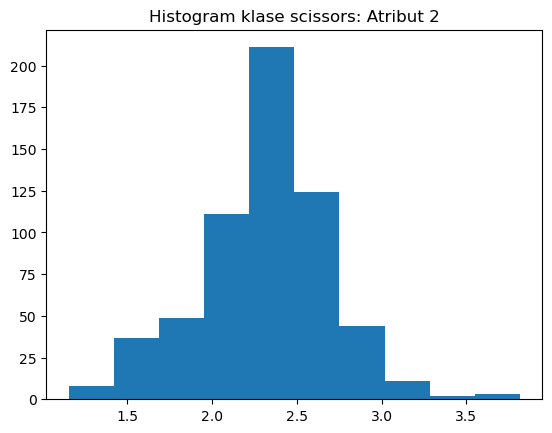

In [27]:
plt.hist(X1[1,:])
plt.title('Histogram klase scissors: Atribut 2')
plt.show()

Nema simetričnosti - izražen skewness - izraženi desni rep.

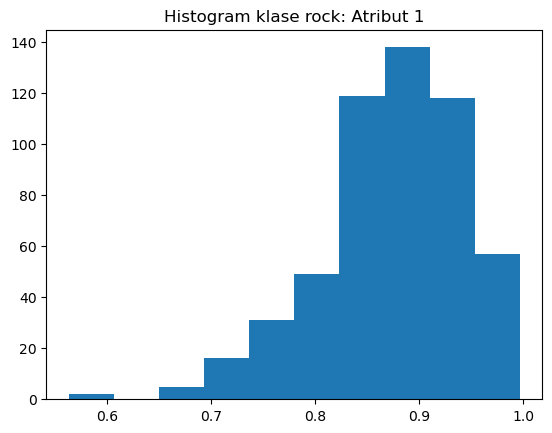

In [28]:
plt.hist(X2[0,:])
plt.title('Histogram klase rock: Atribut 1')
plt.show()

Za razliku od klase 1, ovde nema simetričnosti - međutim to je i za očekivati uzevši u obzir da je maksimalna vrednost ovog atributa 100%, pa samim tim postoji odsecanje desnog dela  raspodela na vrednosti 100. Ovo podesća na normalnu raspodelu, gde postoji limit sa desne strane. Vraijansa je dosta veća nego kod prve klase.

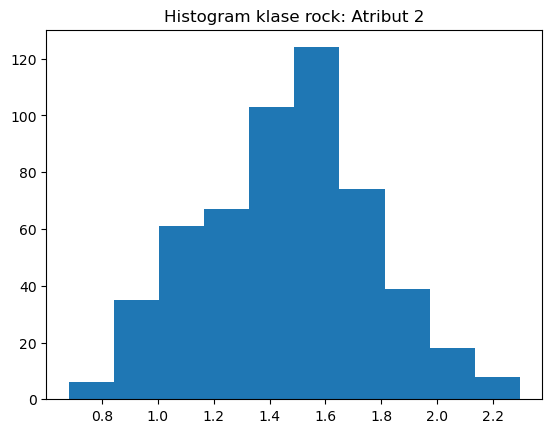

In [29]:
plt.hist(X2[1,:])
plt.title('Histogram klase rock: Atribut 2')
plt.show()

Slično kao i kod klase scissors - izraženi skewness. Centar je pomeren udesno u odnosu na klasu scissors. Vidimo postojanje nekih ekstremnih vrednost u oksegu od 140 do 160.

### Klasifikacija
Za klasifikaciju će biti korišćen linearni klasifikator projektovan drugom numeričkom metodon (metod resupstitucije). Detaljnije o ovom metodu će biti reči u Zadatku 3.

In [30]:
def druga_num_metoda(X1, X2):
    N1 = X1.shape[1]
    N2 = X2.shape[1]
    
    M1_est = np.mean(X1, axis=1).reshape(-1,1)
    M2_est = np.mean(X2, axis=1).reshape(-1,1)
    S1_est = np.cov(X1)
    S2_est = np.cov(X2)    
    
    s = np.arange(0,1,10**-3)
    v0_opt_s = []
    Neps_s = []
    
    for i in range(len(s)):
        V = np.linalg.inv(s[i]*S1_est + (1-s[i])*S2_est)@(M2_est-M1_est)
        Y1 = V.T@X1
        Y2 = V.T@X2
        Y = np.sort(np.concatenate((Y1, Y2), axis=1)) 
        v0 = np.zeros(Y.shape[1]-1) 
        Neps = np.zeros(Y.shape[1]-1)
        for j in range(Y.shape[1]-1):
            v0[j] = -(Y[0,j]+Y[0,j+1])/2
            Neps[j] += np.sum(Y1>-v0[j])
            Neps[j] += np.sum(Y2<-v0[j])  
        Neps_s.append(np.min(Neps))
        v0_opt_s.append(v0[np.argmin(Neps)])
    Neps_opt = min(Neps_s)
    v0_opt = v0_opt_s[np.argmin(Neps_s)]
    s_opt = s[np.argmin(Neps_s)]
    return (s_opt, v0_opt, Neps_opt, M1_est, M2_est, S1_est, S2_est)

In [31]:
s_opt, v0_opt, Neps_opt, M1_est, M2_est, S1_est, S2_est = druga_num_metoda(X1, X2)
V = np.linalg.inv(s_opt*S1_est + (1-s_opt)*S2_est)@(M2_est-M1_est)
v0 = v0_opt

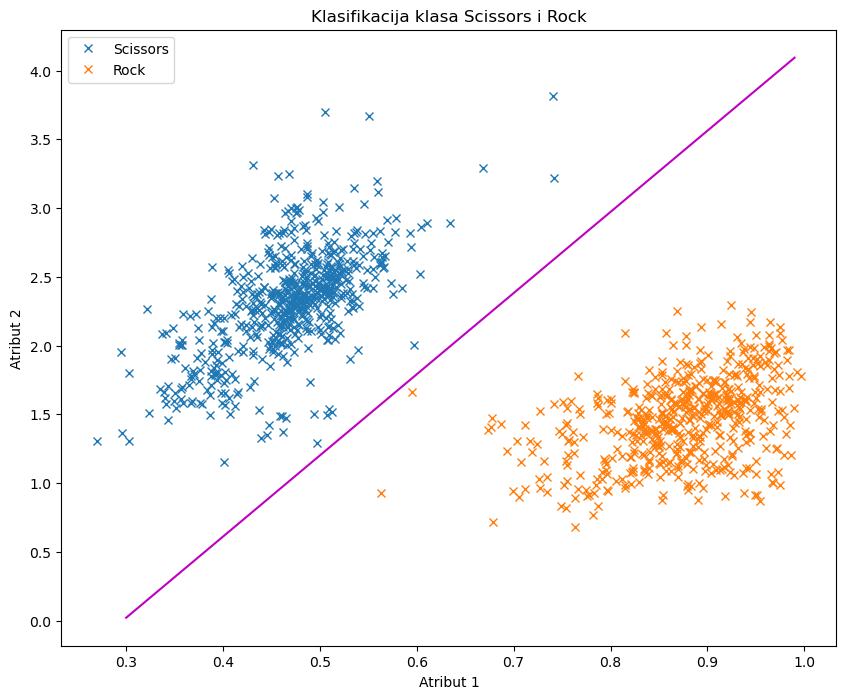

In [32]:
x1 = np.arange(0.3,1,0.01)
x2 = -(v0+V[0]*x1)/V[1]

plt.figure(figsize=(10, 8))
plt.plot(X1[0,:],X1[1,:], 'x')
plt.plot(X2[0,:],X2[1,:], 'x')
plt.plot(x1,x2,'m')
plt.title('Klasifikacija klasa Scissors i Rock')
plt.legend(['Scissors', 'Rock'])
plt.xlabel('Atribut 1')
plt.ylabel('Atribut 2')
plt.show()

#### Performanse na trening skupu

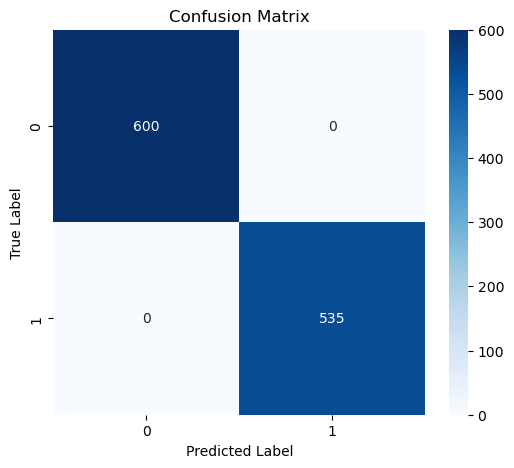

In [33]:
Y_pred = (V.T@X_train+v0)
Y_pred = Y_pred.reshape(-1,)
Y_pred[Y_pred>=0] = 2
Y_pred[Y_pred<0] = 1

plot_cm(Y_train, Y_pred)

Preciznost klasifikatora na test skupu je 100%.

#### Performanse na test skupu

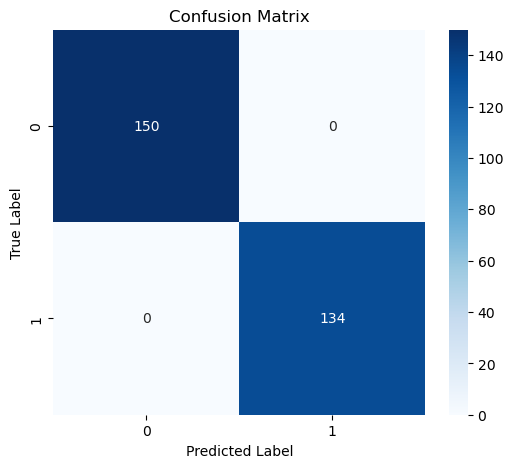

In [34]:
Y_pred = (V.T@X_test+v0)
Y_pred = Y_pred.reshape(-1,)
Y_pred[Y_pred>=0] = 2
Y_pred[Y_pred<0] = 1

plot_cm(Y_test, Y_pred)

Preciznost i na test skupu iznosi 100%. Možemo zaključiti da nije došlo do preobučavanja klasifikatora. 

Isprojektovani sistem za klasifikaciju znakova kamen i makaze klasifikuje odbirke sa velikom preciznošću.